In [7]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import Levenshtein
import time
import torchaudio
import librosa

from morse.models import CNNResidualBlock, TransformerResidualBlock, PoolingTransition, CNNTransformer, CTCHead
from morse.models import MySomething
from morse.models import SimpleCNN
from morse.my_datasets import ListDataset, load_tensors, filenames_to_torch
from morse.samplers import LongCTCSampler
# from morse.augmentations import rotation_transform, volume_signal_transform
from morse.augmentations import make_mel_feature_extraction_transform
from morse.text_helpers import Vectorizer, encode_to_morse, decode_from_morse

from morse.my_datasets import generate_dataset, read_dataset_from_files

In [2]:
labels_dir = '../'
# data_dir = '../data/melspec_nfft512_nc64'
audio_dir = '../morse_dataset'

full_train_df = pd.read_csv(Path(labels_dir, 'train.csv'))
test_df = pd.read_csv(Path(labels_dir, 'test.csv'))
full_train_df.head()

,id,message
0,1.opus,03ЩУЫЛПИГХ
1,2.opus,ЪЛТ0ДС6А3Г
2,3.opus,5ЭКЫБЗХЯН
3,4.opus,ЖЫЦОИ68КФ
4,5.opus,32Ю7МЫ ЗЛ


In [3]:
index_to_letter = sorted(set(''.join(full_train_df['message'])))
pad_value = 0
print(index_to_letter)
letter_to_index = dict([(letter, i) for i, letter in enumerate(index_to_letter)])
dictionary_size = len(index_to_letter)
print(dictionary_size)
print(letter_to_index)

vectorizer = Vectorizer(letter_to_index, index_to_letter)
print(vectorizer.text_transform('ПРИВЕТ #'))

[' ', '#', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']
44
{' ': 0, '#': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'А': 12, 'Б': 13, 'В': 14, 'Г': 15, 'Д': 16, 'Е': 17, 'Ж': 18, 'З': 19, 'И': 20, 'Й': 21, 'К': 22, 'Л': 23, 'М': 24, 'Н': 25, 'О': 26, 'П': 27, 'Р': 28, 'С': 29, 'Т': 30, 'У': 31, 'Ф': 32, 'Х': 33, 'Ц': 34, 'Ч': 35, 'Ш': 36, 'Щ': 37, 'Ъ': 38, 'Ы': 39, 'Ь': 40, 'Э': 41, 'Ю': 42, 'Я': 43}
tensor([27, 28, 20, 14, 17, 30,  0,  1])


In [4]:
device = 'cpu'

In [ ]:
def load_cnnT_model(path):
    dropout = 0.0838

    d_input = 4
    d_model = 128
    d_inner = 128
    d_output = dictionary_size + 1

    n_pools = 4
    n_blocks_before_pool = 3
    n_transformer_blocks = 5
    num_heads = 4       # might be important


    model = CNNTransformer(d_input = d_input, d_model=d_model,
        n_pools=n_pools, n_blocks_before_pool=n_blocks_before_pool,
        n_transformer_blocks=n_transformer_blocks,
        dropout=dropout,
        head_block=CTCHead(d_model, d_output),
        make_cnn_block=lambda: CNNResidualBlock(d_model, d_inner, dropout=dropout),
        make_transformer_block=lambda: TransformerResidualBlock(d_model, d_ffn=d_inner, dropout=dropout, num_heads=num_heads), 
        pooling_overlap=True).to(device)

    model.load_state_dict(torch.load(path, 
                                    weights_only=True, map_location=torch.device('cpu')))
    return model

In [8]:
from sklearn.model_selection import train_test_split

train_index, val_index = train_test_split(np.arange(full_train_df.shape[0]), test_size=1/6, shuffle=True, 
                                           random_state=42)
real_val_set = read_dataset_from_files(audio_dir, 
                                       filenames = full_train_df.iloc[val_index]['id'], 
                                       labels=list(full_train_df.iloc[val_index]['message']), 
                                       mel_spec_transform=make_mel_feature_extraction_transform(4))
print(len(real_val_set))

100%|██████████| 5000/5000 [01:00<00:00, 82.66it/s]

5000


In [9]:
def generate_probs(model, features_):
    ctc_probs = []
    model.eval()
    with torch.no_grad():
        for f in tqdm(features_):
            outs = model(f[None]).squeeze()
            probs = F.softmax(outs, dim=0)
            ctc_probs.append(probs)
    return ctc_probs

In [14]:
def decode_probs_to_messages(probs, beam_size=10):
    decoded = []
    for prob in tqdm(probs):
        seqs, likelihood = LongCTCSampler.sample(prob, beam_size=beam_size)
        text = vectorizer.from_tensor(torch.tensor(seqs) - 1)
        decoded.append(text)
    return decoded

In [15]:
def calculate_mean_distance(decoded_messages, target_messages):
    assert len(decoded_messages) == len(target_messages)
    dist_buffer = []
    for dec, tar in zip(tqdm(decoded_messages), target_messages):
        dist = Levenshtein.distance(dec, tar)
        dist_buffer.append(dist)
    return np.mean(dist_buffer)

In [ ]:
# model = load_cnnT_model('../models/ignored/cnnT_pre30ep_FE_x4_30ep.pt')
# probs = generate_probs(model, [f for f, m in real_val_set])
# print(len(probs))
# print(probs[0].shape)

100%|██████████| 5000/5000 [00:56<00:00, 88.96it/s] 

5000
torch.Size([45, 32])


In [ ]:
# decoded_messages = decode_probs_to_messages(probs, beam_size=10)

100%|██████████| 5000/5000 [05:34<00:00, 14.95it/s]


In [ ]:
# mean_dist = calculate_mean_distance(decoded_messages, [m for f, m in real_val_set])
# mean_dist

100%|██████████| 5000/5000 [00:00<00:00, 714653.94it/s]


np.float64(0.2712)

In [18]:
def predict_decode_and_measure(model_path):
    model = load_cnnT_model(model_path)
    probs = generate_probs(model, [f for f, m in real_val_set])
    decoded_messages = decode_probs_to_messages(probs, beam_size=10)
    mean_dist = calculate_mean_distance(decoded_messages, [m for f, m in real_val_set])
    return probs, mean_dist

In [20]:
stat_fe4_30ep_probs, stat_fe4_30ep_mean_dist = predict_decode_and_measure('../models/ignored/cnnT_pre30ep_FE_x4_30ep.pt')
print(len(stat_fe4_30ep_probs))
print(stat_fe4_30ep_mean_dist)

100%|██████████| 5000/5000 [00:00<?, ?it/s]

5000
0.2712


In [21]:
stat_fe4_20ep_probs, stat_fe4_20ep_mean_dist = predict_decode_and_measure('../models/ignored/cnnT_pre30ep_FE_x4_20ep.pt')
print(len(stat_fe4_20ep_probs))
print(stat_fe4_20ep_mean_dist)

100%|██████████| 5000/5000 [00:00<00:00, 657290.79it/s]

5000
0.2716


In [34]:
stat_fe4_10ep_probs, stat_fe4_10ep_mean_dist = predict_decode_and_measure('../models/ignored/cnnT_pre30ep_FE_x4_10ep.pt')
print(len(stat_fe4_10ep_probs))
print(stat_fe4_10ep_mean_dist)

100%|██████████| 5000/5000 [00:00<?, ?it/s]

5000
0.2748


In [39]:
stat_fe4_probs_averaged_by_checkpoints = torch.mean(torch.stack([
    torch.stack(stat_fe4_10ep_probs),
    torch.stack(stat_fe4_20ep_probs), 
    torch.stack(stat_fe4_30ep_probs)]), dim=0)
_decoded_messages_from_stat_fe4_checkpoint_average_probs = decode_probs_to_messages(stat_fe4_probs_averaged_by_checkpoints, beam_size=10)
mean_dist = calculate_mean_distance(_decoded_messages_from_stat_fe4_checkpoint_average_probs, [m for f, m in real_val_set])

100%|██████████| 5000/5000 [00:00<00:00, 4953122.34it/s]


In [40]:
mean_dist

np.float64(0.2698)

### FEx4 rotated

In [62]:
rotated_fe4_probs_r0, rotated_fe4_mean_dist_r0 = predict_decode_and_measure('../models/ignored/cnnT_pre30ep_FE_x4_rotated_30ep.pt')
print(len(rotated_fe4_probs_r0))
print(rotated_fe4_mean_dist_r0)

100%|██████████| 5000/5000 [00:00<?, ?it/s]

5000
0.2844


In [64]:
def make_const_runtime_rotation_transform(shift):
    def tr(mel: torch.Tensor):
        threshold = shift
        result = torch.concat([mel[threshold:], mel[:threshold]], dim=0)
        return result
    return tr

In [65]:
real_val_set.transform = make_const_runtime_rotation_transform(shift=1)
rotated_fe4_probs_r1, rotated_fe4_mean_dist_r1 = predict_decode_and_measure('../models/ignored/cnnT_pre30ep_FE_x4_rotated_30ep.pt')
print(len(rotated_fe4_probs_r1))
print(rotated_fe4_mean_dist_r1)
real_val_set.transform = lambda x: x

100%|██████████| 5000/5000 [00:00<00:00, 999167.18it/s]

5000
0.287


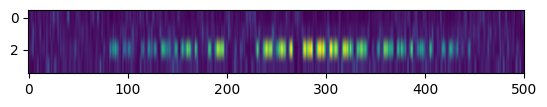

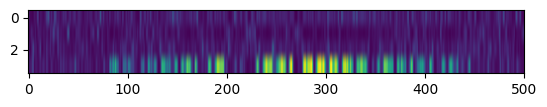

In [74]:
plt.imshow(real_val_set[0][0], aspect=16)
plt.show()

real_val_set.transform = make_const_runtime_rotation_transform(shift=3)

plt.imshow(real_val_set[0][0], aspect=16)
plt.show()

real_val_set.transform = lambda x: x

In [71]:
real_val_set.transform = make_const_runtime_rotation_transform(shift=2)
rotated_fe4_probs_r2, rotated_fe4_mean_dist_r2 = predict_decode_and_measure('../models/ignored/cnnT_pre30ep_FE_x4_rotated_30ep.pt')
print(len(rotated_fe4_probs_r2))
print(rotated_fe4_mean_dist_r2)
real_val_set.transform = lambda x: x

100%|██████████| 5000/5000 [00:00<?, ?it/s]

5000
0.2874


In [72]:
real_val_set.transform = make_const_runtime_rotation_transform(shift=3)
rotated_fe4_probs_r3, rotated_fe4_mean_dist_r3 = predict_decode_and_measure('../models/ignored/cnnT_pre30ep_FE_x4_rotated_30ep.pt')
print(len(rotated_fe4_probs_r3))
print(rotated_fe4_mean_dist_r3)
real_val_set.transform = lambda x: x

100%|██████████| 5000/5000 [00:00<00:00, 1650131.40it/s]

5000
0.2812


In [ ]:
rotated_fe4_probs_averaged_by_rotation = torch.mean(torch.stack([
    torch.stack(rotated_fe4_probs_r0),
    torch.stack(rotated_fe4_probs_r1),
    torch.stack(rotated_fe4_probs_r2), 
    torch.stack(rotated_fe4_probs_r3)]), dim=0)
_decoded_messages_from_rotated_fe4_averaged_probs = decode_probs_to_messages(rotated_fe4_probs_averaged_by_rotation, beam_size=10)
_mean_dist = calculate_mean_distance(_decoded_messages_from_rotated_fe4_averaged_probs, [m for f, m in real_val_set])
print(_mean_dist)

100%|██████████| 5000/5000 [00:00<00:00, 1609356.15it/s]

0.2802


In [75]:
super_average = (stat_fe4_probs_averaged_by_checkpoints + rotated_fe4_probs_averaged_by_rotation) / 2

_decoded_super_average = decode_probs_to_messages(super_average, beam_size=10)
_mean_dist_super_average = calculate_mean_distance(_decoded_super_average, [m for f, m in real_val_set])
print(_mean_dist_super_average)

100%|██████████| 5000/5000 [00:00<00:00, 1188188.10it/s]

0.2662


In [76]:
_decoded_super_average = decode_probs_to_messages(super_average, beam_size=19)
_mean_dist_super_average = calculate_mean_distance(_decoded_super_average, [m for f, m in real_val_set])
print(_mean_dist_super_average)

100%|██████████| 5000/5000 [00:00<00:00, 1714199.77it/s]

0.266


#### model learned on x12 data

In [87]:
real_val_set.transform = make_const_runtime_rotation_transform(shift=0)
rotated_fe12_probs_r0, rotated_fe12_mean_dist_r0 = predict_decode_and_measure('../models/ignored/cnnT_pre30ep_FE_x12_rotated_30ep.pt')
print(len(rotated_fe12_probs_r0))
print(rotated_fe12_mean_dist_r0)
real_val_set.transform = lambda x: x

100%|██████████| 5000/5000 [00:00<00:00, 1244600.59it/s]

5000
0.2688


In [88]:
real_val_set.transform = make_const_runtime_rotation_transform(shift=3)
rotated_fe12_probs_r3, rotated_fe12_mean_dist_r3 = predict_decode_and_measure('../models/ignored/cnnT_pre30ep_FE_x12_rotated_30ep.pt')
print(len(rotated_fe12_probs_r3))
print(rotated_fe12_mean_dist_r3)
real_val_set.transform = lambda x: x

100%|██████████| 5000/5000 [00:00<?, ?it/s]

5000
0.2682


In [91]:
real_val_set.transform = make_const_runtime_rotation_transform(shift=1)
rotated_fe12_probs_r1, rotated_fe12_mean_dist_r1 = predict_decode_and_measure('../models/ignored/cnnT_pre30ep_FE_x12_rotated_30ep.pt')
print(len(rotated_fe12_probs_r1))
print(rotated_fe12_mean_dist_r1)
real_val_set.transform = lambda x: x

100%|██████████| 5000/5000 [00:00<00:00, 1987068.41it/s]

5000
0.2722


In [92]:
real_val_set.transform = make_const_runtime_rotation_transform(shift=2)
rotated_fe12_probs_r2, rotated_fe12_mean_dist_r2 = predict_decode_and_measure('../models/ignored/cnnT_pre30ep_FE_x12_rotated_30ep.pt')
print(len(rotated_fe12_probs_r2))
print(rotated_fe12_mean_dist_r2)
real_val_set.transform = lambda x: x

100%|██████████| 5000/5000 [00:00<00:00, 851220.52it/s]

5000
0.2712


In [89]:
average_probs_of_best_statx4_and_rotated_x12 = torch.mean(torch.stack([
    torch.stack(stat_fe4_20ep_probs), 
    torch.stack(stat_fe4_30ep_probs),
    torch.stack(rotated_fe12_probs_r0),
    torch.stack(rotated_fe12_probs_r3)]), dim=0)

_decoded_average_of_best_statx4_and_rotated_x12 = decode_probs_to_messages(average_probs_of_best_statx4_and_rotated_x12, beam_size=10)
_mean_dist_of_best_statx4_and_rotated_x12 = calculate_mean_distance(_decoded_average_of_best_statx4_and_rotated_x12, [m for f, m in real_val_set])
print(_mean_dist_of_best_statx4_and_rotated_x12)

100%|██████████| 5000/5000 [00:00<?, ?it/s]

0.263


In [90]:
average_probs_of_best_statx4_and_rotated_x12_and_rotated_x4 = torch.mean(torch.stack([
    torch.stack(stat_fe4_20ep_probs), 
    torch.stack(stat_fe4_30ep_probs),
    torch.stack(rotated_fe12_probs_r0),
    torch.stack(rotated_fe12_probs_r3),
    torch.stack(rotated_fe4_probs_r1),
    torch.stack(rotated_fe4_probs_r2)]), dim=0)

_decoded_average_of_best_statx4_and_rotated_x12_and_rotated_x4 = decode_probs_to_messages(average_probs_of_best_statx4_and_rotated_x12_and_rotated_x4, beam_size=10)
_mean_dist_of_best_statx4_and_rotated_x12_and_rotated_x4 = calculate_mean_distance(_decoded_average_of_best_statx4_and_rotated_x12_and_rotated_x4, [m for f, m in real_val_set])
print(_mean_dist_of_best_statx4_and_rotated_x12_and_rotated_x4)

100%|██████████| 5000/5000 [00:00<00:00, 2562189.37it/s]

0.2614


In [93]:
average_probs_of_best_statx4_and_rotated_x12_only = torch.mean(torch.stack([
    torch.stack(stat_fe4_20ep_probs), 
    torch.stack(stat_fe4_30ep_probs),
    torch.stack(rotated_fe12_probs_r0),
    torch.stack(rotated_fe12_probs_r3),
    torch.stack(rotated_fe12_probs_r1),
    torch.stack(rotated_fe12_probs_r2)]), dim=0)

_decoded_average_of_best_statx4_and_rotated_x12_only = decode_probs_to_messages(average_probs_of_best_statx4_and_rotated_x12_only, beam_size=10)
_mean_dist_of_best_statx4_and_rotated_x12_only = calculate_mean_distance(_decoded_average_of_best_statx4_and_rotated_x12_only, [m for f, m in real_val_set])
print(_mean_dist_of_best_statx4_and_rotated_x12_only)

100%|██████████| 5000/5000 [00:00<?, ?it/s]

0.2622


# predicting a submission

In [43]:
test_set = read_dataset_from_files(audio_dir, 
                                       filenames = test_df['id'], 
                                       labels=['' for i in range(5000)],
                                       mel_spec_transform=make_mel_feature_extraction_transform(4))
print(len(test_set))

100%|██████████| 5000/5000 [00:59<00:00, 83.92it/s]

5000


for this submission i will use ensemble of models and a bit of test time augmentation

In [94]:
test_probs_list = []

test_set.transform = lambda x: x
model = load_cnnT_model('../models/ignored/cnnT_pre30ep_FE_x4_30ep.pt')     # last checkpoint of stationary model
test_probs_list.append(generate_probs(model, [f for f, m in test_set]))

model = load_cnnT_model('../models/ignored/cnnT_pre30ep_FE_x4_20ep.pt')     # previous checkpoint of stationary model
test_probs_list.append(generate_probs(model, [f for f, m in test_set]))


model = load_cnnT_model('../models/ignored/cnnT_pre30ep_FE_x12_rotated_30ep.pt')  # rotatable model trained on 12 x 30k data points
test_set.transform = make_const_runtime_rotation_transform(shift=0) # actually this is just no rotation
test_probs_list.append(generate_probs(model, [f for f, m in test_set]))

test_set.transform = make_const_runtime_rotation_transform(shift=3)     # rotated 1 cell down
test_probs_list.append(generate_probs(model, [f for f, m in test_set]))     # using the same model here - so this is test time augs

model = load_cnnT_model('../models/ignored/cnnT_pre30ep_FE_x4_rotated_30ep.pt')     # rotatable model trained on 4 x 30k data
test_set.transform = make_const_runtime_rotation_transform(shift=1)     # different rotation
test_probs_list.append(generate_probs(model, [f for f, m in test_set]))

test_set.transform = make_const_runtime_rotation_transform(shift=2)
test_probs_list.append(generate_probs(model, [f for f, m in test_set]))

test_set.transform = lambda x: x       # restore

100%|██████████| 5000/5000 [00:59<00:00, 83.91it/s] 


In [98]:
submission_probs = []
for i in range(len(test_probs_list[0])):
    submission_probs.append(torch.mean(torch.stack([p[i] for p in test_probs_list], dim=0), dim=0))

print(len(submission_probs))
print(submission_probs[0].shape)
print(submission_probs[-1].shape)

5000
torch.Size([45, 32])
torch.Size([45, 188])


In [99]:
test_decoded_list = decode_probs_to_messages(submission_probs, beam_size=10)
print(len(test_decoded_list))

100%|██████████| 5000/5000 [05:40<00:00, 14.67it/s]

5000


In [102]:
submission_df = pd.DataFrame({'id': test_df['id'], 'message': test_decoded_list})
submission_df.head()

,id,message
0,30001.opus,ЯЮ6ЛИТЖБШ
1,30002.opus,КЩ В9Ю 9
2,30003.opus,Ы65Ф61Я
3,30004.opus,ЖЖНЖ9РЫНЦ3
4,30005.opus,ЕЯФ4ЮЧЬ


In [106]:
submission_df.tail()

,id,message
4995,34996.opus,ОРСКС ИЛ ДАСДП ЬСОЕМУАТИ ЕНБАЛ КНРТЕАЛШ ВДМУНЕ...
4996,34997.opus,ОИСЧТИ СЕЬКНДМЕП ЮН ДНИМ ОЬНОМЕТЫПАЛБ ЖТЫАСР
4997,34998.opus,ТОЫМ ДЛ ЬСЧТЫНТЕТ ДТКАГЕПОЦ ВСИСБ НН
4998,34999.opus,ОДТЕ ОСЫАЯН ВНКМЕ ЧМЮАП РНЧВСИГ
4999,35000.opus,РСАТЯ ЬТКТВНЖМ


## star decoding

подробнее историю расшифровки можно посмотреть в star_task.ipynb

сигнал был считан в полуручном режиме - специально обученная модель предсказывала сообщение, а потом я руками проверял и справлял неточности

хотя похоже модель даже лучше справляется (что меня немного удивляет - это же трансформер не обученный на таких длинных последовательностях)

In [107]:
actual_morse = [''] * 17
idx = 0
actual_morse[idx] = '-.. .- -- .. -. .- -- - / -.. --- - .. / .-. ... -.-- ... .- -- -.-. ..'
idx = 1
actual_morse[idx] = '.. .-.. / -..- ... .-- . -.. - -.- ---. .-- -. - .. / .-.- -- -.. -- -.-- -- ..-- -. .-.- -- -.-. / ..-- - .. -.-- -- -..- - -.- - ---. -- -.-- -. / -.. - -.-- -- .-. --. --.. / . .--. .. --.'
idx = 2
actual_morse[idx] = '.- -. .... / .-- ... --- . --. -..- / .-. / .-- -.- - -.. .- -- .. / -. -.- ---- -- -.. -. .. / --. . -.- -. ...- - .-'
idx = 3
actual_morse[idx] = '.. .-.. / -.. .- ... -.. .--. / -..- ... --- . -- ..- -. - .. / .. --. .-- -.- ... --- . .--. / -..- -.- ... .... -.-- ... ..- ... / .... -. ..- / ..-- -. / .... -. .... -. ..- ... ..'
idx = 4
actual_morse[idx] = '. - -..- - -.- .--. / -.. ... .-.- -. -.- -- -.-- --- -.-. / .. -- -.-'
idx = 5
actual_morse[idx] = '-.- -. --- -..- -.- -- / ... --- . -. -.-- -- --- .--. / -..- ... ..-- -. .-- --'
idx = 6
actual_morse[idx] = '.. .-.. / -..- ... --- . -. -.. -- -.-- -- / .--- -.-- -. ..- ... / .--- -.-- -- ---. .- - ..- ... / -..- -.- - -.. .-.. .... - / -.-- -- ...- .- .-.. ---- / -. .-.. ..- ... .-- / -- / ---. - -.-- -. .- -- -...'
idx = 7
actual_morse[idx] = '-- .-.. / -.. .- ... -.. .--. / --- ... ..-- .-- -. -.-- -- / -. ..-- .--- --. .-. --. / . - -.-- - ..- -.- -. --.- -.'
idx = 8
actual_morse[idx] = '.- ... / .- - / .. ... ---. - .. / -.- -.- ...- -. . .--. --- -.-. / ..-- -. /  -. .--- --- ... -.-- --.. . .- --. --.. / -.. - -.- .- ... --- . .--. / --- -- .. -.. ... -.-- ... ....'
idx = 9
actual_morse[idx] = '- --- -.-- -- / -.. .-.. / --- -.-- .-.. .... -- . - / --.-- . ... / -..- ... --- -.-- -. ... -- - / . ... / ... . .-. -.-- -. ... -- - / . ... / ... . .-. -.-- -- .-. .- -- . - --- .--.'
idx = 10
actual_morse[idx] = '.- -. / ...- -. --- . ... . - / -..- - -.- - .-- -. ...- -- / --. -.. - -.-- -- ...- - .- .- ... -... / .- -. / --... ..... / .-. -- -.-- ... .-.- -- .-. -.-- ... -..'
idx = 11
actual_morse[idx] = '--- -.. -.-. ..-- .--. / -..- ... .-- .-- - -.- ---. -- -.. -. - . --- -.-. / -.. -.- --. ...- .- --. --.. / .- - --. . ... .. -- .. .-.. .. -- / -.-- -. -.-- .--. .-.- -. .. -- / .- -. .... -- ---- / ... -..- - -.- -. . ... -.- ... -..'
idx = 12
actual_morse[idx] = '--- .-. ... -.- ... / .. .-.. / -.. .- ... -.. .--. / -..- ... --- . -- ..- .- - .. / . -. -... .- .-.. / -.- -. .-. - . .- .-.. ---- / .-- -.. -- ..- -. . - -.-- - -...'
idx = 13
actual_morse[idx] = '--- .. ... ---. - .. / ... . -..- -.- -. -.. -- . .--. / ..-- -. / -.. -. .. -- / --- -..- -. --- -- . - -.-- .--. .- .-.. -... -... / ...- - -.-- .- ... .-.'
idx = 14
actual_morse[idx] = '- --- -.-- -- / -.. .-.. / -..- ... ---. - -.-- -. - . - / -.. - -.- .- --. . .--. --- -.-. / .-- ... .. ... -... / -. -.'
idx = 15
actual_morse[idx] = '--- -.. - . / --- ... -.-- .- .-.- -. / .-- -. -.- -- . / ---. -- ..-- .- .--. / .-. -. ---. .-- ... .. --.'
idx = 16
actual_morse[idx] = '.-. ... .- - .-.- / -..- - -.- - .-- -. ...- --'

In [108]:
full_text = ' '.join([decode_from_morse(m) for m in actual_morse])

In [109]:
def replace_with_map(mapping, text):
    result = []
    for ch in text:
        if ch in mapping:
            result.append(mapping[ch])
        else:
            result.append(ch)
    return ''.join(result)

def make_map(keys, vals):
    mapping = dict()
    for k, v in zip(keys, vals):
        mapping[k] = v
    return mapping

In [110]:
# from collections import Counter

# cyphered_most_common = [k for k, v in Counter(text).most_common()]
# reference_most_common = [k for k, v in Counter(reference_text).most_common()]

# # print(list(Counter(text).most_common()))
# # print(list(Counter(reference_text).most_common()))

# reference_map = dict()
# for c, r in zip(cyphered_most_common, reference_most_common):
#     reference_map[c] = r

true_map = {
    '7': '7',
    '5': '5',
    'Л': 'Ы',
    'П': 'Ь',
    'Ч': 'Ж',
    'С': 'О',
    'Ы': 'Л',
    'Й': 'Б',
    'У': 'Г',
    'Р': 'К',
    'Ц': 'Я',
    'Я': 'Ц',
    'Ю': 'З',
    'К': 'Р',
    'Е': 'Т',
    'Ь': 'П',
    'Ш': 'Х',
    'В': 'Д',
    'Г': 'У',
    'Х': 'Ш',
    'З': 'Ю',
    'Ж': 'Ч',
    'Щ': 'Ф',
    'Б': 'Й',
    **make_map('ДАМИНАМТ ДОТИ', 'ВНИМАНИЕ ВСЕМ'),
}

# to_lower_map = dict()
# for c in cyphered_most_common:
#     to_lower_map[c] = c.lower()

replace_with_map({**true_map}, full_text)

'ВНИМАНИЕ ВСЕМ КОЛОНИЯМ МЫ ПОДТВЕРЖДАЕМ ЦИВИЛИЗАЦИЯ ЗЕМЛИПЕРЕЖИЛА ВЕЛИКУЮ ТЬМУ НАШ ДОСТУП К ДРЕВНИМ АРХИВАМ УТРАЧЕН МЫ ВНОВЬ ПОСТИГАЕМ МУДРОСТЬ ПРОШЛОГО ШАГ ЗА ШАШАГОМ ТЕПЕРЬ ВОЦАРИЛСЯ МИР РАСПРИ ОСТАЛИСЬ ПОЗАДИ МЫ ПОСТАВИЛИ БЛАГО БЛИЖНЕГО ПРЕВЫШЕ ЛИЧНЫХ АЫГОД И ЖЕЛАНИЙ ИЫ ВНОВЬ СОЗДАЛИ АЗБУКУ ТЕЛЕГРАФА НО НЕ МОЖЕМ РРЧАТЬСЯ ЗА АБСОЛЮТНУЮ ВЕРНОСТЬ СИМВОЛОШ ЕСЛИ ВЫ СЛЫШИТЕ #ТО ПОСЛАОИЕ ТО ОТКЛАОИЕ ТО ОТКЛИКНИТЕСЬ НА ЧАСТОТЕ ПЕРЕДАЧИ УВЕЛИЧЕННОЙ НА 75 КИЛОЦИКЛОВ СВЯЗЬ ПОДДЕРЖИВАЕТСЯ ВРУЧНУЮ НЕУТОМИМЫМИ ЛАЛЬЦАМИ НАШИХ ОПЕРАТОРОВ СКОРО МЫ ВНОВЬ ПОСТИГНЕМ ТАЙНЫ РАКЕТНЫХ ДВИГАТЕЛЕЙ СМОЖЕМ ОТПРАВИТЬ ЗА ВАМИ СПАСИТЕЛЬНЫЙЙ ЧЕЛНОК ЕСЛИ ВЫ ПОЖЕЛАЕТЕ ВЕРНУТЬСЯ ДОМОЙ АА СВЕТ СОЛНЦА ДАРИТ ЖИЗНЬ КАЖДОМУ КОНЕЦ ПЕРЕДАЧИ'

In [114]:
model_full_text_decoded = ' '.join(test_decoded_list[-17:])
print('automatic: ', replace_with_map(true_map, model_full_text_decoded))
print('by hand:   ', replace_with_map({**true_map}, full_text))

automatic:  ВНИМАНИЕ ВСЕМ КОЛ НИЯ МЫ ПОДТВЕРЖДАЕМ ЦИВИЛИЗАЦИЯ ЗЕМЛИ ПЕРЕЖИЛА ВЕЛИКУЮ ТЬМУ НАШ ДОСТУП К ДРЕВНИМ АРХИВАМ УТРАЧЕН МЫ ВНОВЬ ПОСТИГАЕМ МУДРОСТЬ ПРОШЛОГО ШАГ ЗА ШАГОМ ТЕПЕРЬ ВОЦАРИЛСЯ МИР РАСПРИ ОСТАЛИСЬ ПОЗАДИ МЫ ПОСТАВИЛИ БЛАГО БЛИЖНЕГО ПРЕВЫШЕ ЛИЧНЫХ ВЫГОД И ЖЕЛАНИЙ МЫ ВНОВЬ СОЗДАЛИ АЗБУКУ ТЕЛЕГРАФА НО НЕ МОЖЕМ РУЧАТЬСЯ ЗА АБСОЛЮТЪЮ ВЕРНОСТЬ СИМВОЛОВ СЛИВЫ СЛЫШИТЕ #ТО ПОСЛАИЕ ТОТКЛКНИТЕСЬ НА ЧАСТОТЕ ПЕРЕДАЧИ УВЕЛИЧЕННОЙ НА 75 КИЛОЦИКЛОВ СВЯЗЬ ПОДДЕРЖИВАЕТСЯ ВРУЧНУЮ НЕУТОМИМЫМИ ПАЛЬЦАМИ НАШИХ ОПЕРАТОРОВ СКОРО МЫ ВНОВЬ ПОСТИГНЕМ ТАЙНЫ РАКЕТНЫХ ДВИГАТЕЛЕЙ СМОЖЕМ ОТПРАВИТЬ ЗА ВАМИ СПАСИТЕЛЬНЫЙ ЧЕЛНОК ЕСЛИ ВЫ ПОЖЕЛАЕТЕ ВЕРНУТЬСЯ ДОМОЙ АА СВЕТ СОЛНЦА ДАРИТ ЖИЗНЬ КАЖДОМУ КОНЕЦ ПЕРЕДАЧИ
by hand:    ВНИМАНИЕ ВСЕМ КОЛОНИЯМ МЫ ПОДТВЕРЖДАЕМ ЦИВИЛИЗАЦИЯ ЗЕМЛИПЕРЕЖИЛА ВЕЛИКУЮ ТЬМУ НАШ ДОСТУП К ДРЕВНИМ АРХИВАМ УТРАЧЕН МЫ ВНОВЬ ПОСТИГАЕМ МУДРОСТЬ ПРОШЛОГО ШАГ ЗА ШАШАГОМ ТЕПЕРЬ ВОЦАРИЛСЯ МИР РАСПРИ ОСТАЛИСЬ ПОЗАДИ МЫ ПОСТАВИЛИ БЛАГО БЛИЖНЕГО ПРЕВЫШЕ ЛИЧНЫХ АЫГОД И ЖЕЛАНИЙ ИЫ ВНОВЬ СОЗДАЛИ 

сделаю на предсказаниях модели

In [115]:
# submission_file = '../submission.csv'
# submission = pd.read_csv(submission_file)

for i in range(17):
    message = test_decoded_list[-17 + i]
    submission_df.iloc[-17 + i, 1] = replace_with_map(true_map, message)
# submission.to_csv('../decoded_submission.csv', index=False)

In [116]:
submission_df.to_csv('../submission.csv', index=False)